In [4]:
from nn import NN
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import numpy as np

In [6]:
# Step 1: Generate a synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=10, random_state=42)

# Step 2: Split the data
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Instantiate and train the model
model = NN(hidden_layer_size=10, n_hidden_layers=2, activation="relu", sel_feat=True)
model.fit(
    x_train,
    y_train,
    x_val,
    y_val,
    epochs=1000,
    patience=3,
    batch_size=32,
    learning_rate=0.001,
    lambda_val=1.0,
    alpha=0.001,
)

# Step 4: Evaluate the model
r2_score_val = model.score(x_val, y_val)
print(f"Validation R-squared: {r2_score_val}")

# Step 5: Print the feature selection weights
feature_weights = model.get_feature_selection_weights()

Validation R-squared: [ 60763.16   38532.215  66553.72   48182.54   49320.195  45662.32
  66294.39   39869.65   56115.945  84190.72   50640.953 135101.23
  61565.754 190011.88   53955.16  140242.53  167512.64   49133.42
  39697.047  42419.96   65465.29   39107.01   57547.305  43534.11
  39272.94  194889.6    61348.09  181370.4    43753.63   56600.484
 354830.3    44733.37   57165.676  58572.363  39544.84   41316.94
 145717.56   72675.1    76660.53   64863.6    38294.96  169965.7
 118486.52  103028.78   56474.95   72280.22   44568.45   38470.15
  51193.676  67187.26   40937.54   39250.34   38677.547  58183.72
  52157.87  285236.62   54693.28  133296.92   72945.15   73331.17
  40369.297 147314.73   42929.15   38242.684  57018.15   44024.44
  54265.07   88605.2    68595.05   40982.188  60679.48   42136.676
  92740.16   45155.094  53218.97   41008.746  47212.33   49867.1
  46140.27   65009.03   53132.52  302233.72   42467.49   38365.45
 254894.6    71134.65   55300.227  38298.496  70705.5 

In [11]:
np.abs(feature_weights).min()

1.8008563e-05

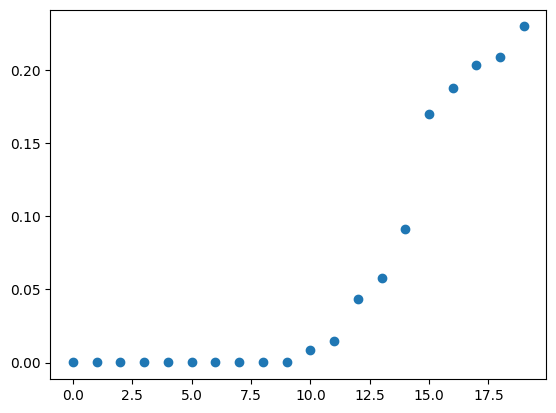

In [10]:
plt.plot(np.sort(np.abs(feature_weights)), "o")